In [1]:
import sklearn as skl
import sklearn_som
from sklearn_som.som import SOM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
raw_data = pd.read_csv('/project2/chihway/raulteixeira/data/DELVE_BDF_data_with_zspec022123.csv.gz')
raw_data

,Unnamed: 0,index,COADD_OBJECT_ID,RA,DEC,BDF_MAG_G,BDF_MAG_R,BDF_MAG_I,BDF_MAG_Z,BDF_MAG_ERR_G,...,BDF_FLUX_G,BDF_FLUX_R,BDF_FLUX_I,BDF_FLUX_Z,BDF_FLUX_ERR_G,BDF_FLUX_ERR_R,BDF_FLUX_ERR_I,BDF_FLUX_ERR_Z,TILENAME,zspec
0,0,45,7204562731,172.389118,15.056227,21.644035,19.796289,19.055787,18.639366,0.026064,...,2199.815036,12063.806905,23860.810196,35014.956172,52.809072,157.613578,348.215053,510.825871,DES1128+1500,0.461965
1,1,394,7139847293,159.253475,-4.607053,18.591030,18.680872,18.905140,18.765181,0.004529,...,36609.011362,33701.658587,27412.197575,31183.693499,152.723218,159.906373,143.490670,219.327667,DES1036-0416,0.017900
2,2,718,7117818939,154.936114,22.370433,22.688729,21.821122,20.971879,20.638015,0.059973,...,840.443156,1868.749376,4085.529818,5556.406185,46.423499,87.014410,217.105310,227.900938,DES1018+2208,0.806231
3,3,870,7237535681,178.410513,4.864691,21.116759,19.360518,18.637276,18.211875,0.020877,...,3575.166603,18021.578953,35082.439456,51909.863323,68.744508,233.558023,445.660601,632.244552,DES1154+0500,0.479938
4,4,1052,6984519918,128.789129,4.640624,17.764402,17.088266,16.687023,16.470139,0.002219,...,78386.154366,146114.636611,211441.717449,258192.960401,160.212154,479.509090,466.448864,586.930709,DES0836+0418,0.108335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512666,95336,2489305,7077058231,146.538866,3.847445,20.973714,19.281648,18.710595,18.404862,0.015164,...,4078.631676,19379.417121,32791.563861,43456.561762,56.965060,187.909269,339.550212,417.102162,DES0947+0335,0.350762
512667,95337,2489469,7170661334,165.395724,6.380626,22.195837,20.312585,19.555053,19.136724,0.038457,...,1323.321361,7498.354191,15065.336447,22146.765972,46.871900,120.119617,275.512230,329.075353,DES1102+0626,0.463140
512668,95338,2489502,7135785104,158.191184,0.152776,17.291605,16.650651,16.369901,16.162081,0.001283,...,121159.622774,218644.959051,283164.926465,342899.978999,143.209249,322.433067,444.049989,652.977960,DES1033+0001,0.065429
512669,95339,2489530,7135773644,158.109621,0.332401,22.470644,21.781404,21.571506,21.506960,0.022958,...,1027.407046,1938.377551,2351.783935,2495.836006,21.724307,62.019687,66.310141,152.393358,DES1033+0001,0.293900


(array([   264.,   8515.,  55787., 114133., 128101., 111355.,  82585.,
          7991.,   3770.,    170.]),
 array([12.74886889, 14.10105334, 15.45323778, 16.80542223, 18.15760667,
        19.50979112, 20.86197557, 22.21416001, 23.56634446, 24.9185289 ,
        26.27071335]),
 <BarContainer object of 10 artists>)

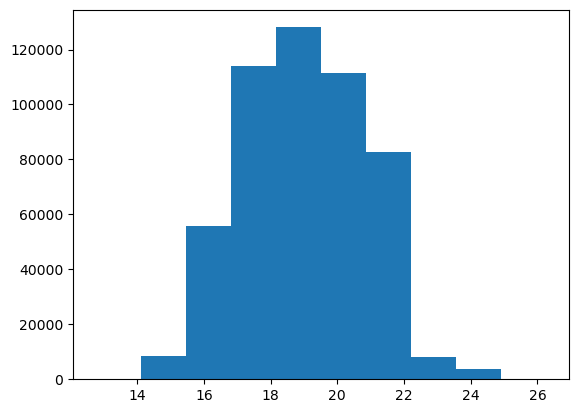

In [3]:
plt.hist(raw_data[f'BDF_MAG_I'])

In [4]:
mag_mask = raw_data[f'BDF_MAG_I'].values<24.0

In [5]:
fluxes = np.array([raw_data[f'BDF_FLUX_{band}'].values[mag_mask] for band in ['I', 'G', 'R', 'Z']]).T
fluxes_var = np.array([raw_data[f'BDF_FLUX_ERR_{band}'].values[mag_mask] for band in ['I', 'G', 'R', 'Z']]).T

In [6]:
def luptize(flux, var, s, zp):
    # s: measurement error (variance) of the flux (with zero pt zp) of an object at the limiting magnitude of the survey
    # a: Pogson's ratio
    # b: softening parameter that sets the scale of transition between linear and log behavior of the luptitudes
    #print(s.shape)
    a = 2.5 * np.log10(np.exp(1)) 
    b = a**(1./2) * s 
    mu0 = zp -2.5 * np.log10(b)

    # turn into luptitudes and their errors
    #print(mu0.shape, flux.shape, b.shape)
    lupt = mu0 - a * np.arcsinh(flux / (2 * b))
    lupt_var = a ** 2 * var / ((2 * b) ** 2 + flux ** 2)
    return lupt, lupt_var

def luptize_wide(flux, var=0, zp=22.5):
    """ The flux must be four dimensional and must be given in the order [f_i, f_g, f_r, f_z] to match the ordering of the softening parameter b """
    #lim_mags = np.array([22.9, 23.7, 23.5, 22.2]) # old
    # see ../test/full_run_on_data/limiting_mags_in_data.ipynb
    lim_mags = np.array([22.92, 23.7, 23.49, 22.28]) # g band is copied from commented array above because g band is not in up to date mastercat
    s = (10**((zp - lim_mags) / 2.5)) / 10  # des limiting mag is 10 sigma

    return luptize(flux, var, s, zp)

def luptize_deep(flux, var=0, zp=22.5):
    """The flux must be 8 dimensional and must be given in the order [f_i, f_g, f_r, f_z, f_u, f_Y, f_J, f_H, f_K] to match the ordering of the softening parameter b """
    #lim_mags_des = np.array([22.9, 23.7, 23.5, 22.2, 25]) # old
    #lim_mags_vista = np.array([24.6, 24.5, 24.0, 23.5]) # old
    lim_mags_des = np.array([24.66, 25.57, 25.27, 24.06, 24.64])
    lim_mags_vista = np.array([24.02, 23.69, 23.58]) # y band value is copied from array above because Y band is not in the up to date catalog
    s_des = (10**((zp-lim_mags_des)/2.5)) / 10  # des limiting mag is 10 sigma
    s_vista = (10**((zp-lim_mags_vista)/2.5)) / 10  # vista limiting mag is 10 sigma

    s = np.concatenate([s_des, s_vista])

    return luptize(flux, var, s, zp)

In [7]:
lupts = np.array([luptize_wide(flux, var=flux_var) for (flux, flux_var) in zip(fluxes, fluxes_var)])
luptitudes, lupts_var = lupts[:,0], lupts[:,1]

In [8]:
lupt_i, lupt_g, lupt_r, lupt_z = luptitudes.T
lupt_gi, lupt_ri, lupt_zi = lupt_g-lupt_i, lupt_r-lupt_i, lupt_z-lupt_i
inputt = np.array([lupt_i, lupt_gi, lupt_ri, lupt_zi]).T

In [130]:
inputt.shape

(510451, 4)

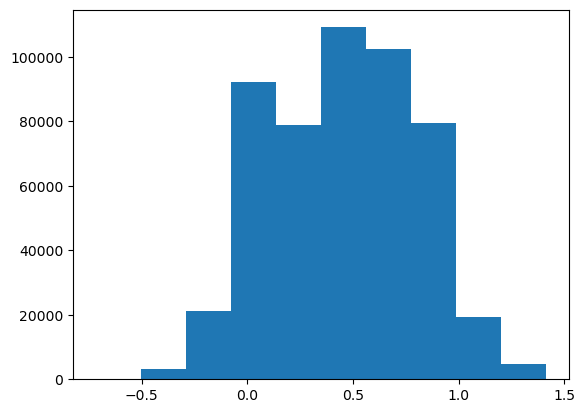

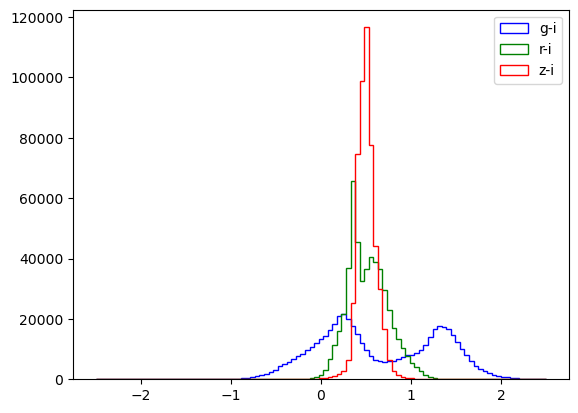

In [9]:
#normalizing i-band luptitude
median_i = np.median(lupt_i)
std_i = np.std(lupt_i)

nlupt_i = (lupt_i-median_i)/std_i
plt.hist(nlupt_i*0.34+0.5)
plt.show()
#normalizing colors
median_gi, median_ri, median_zi = np.median(lupt_gi), np.median(lupt_ri,), np.median(lupt_zi,)
std_c = np.mean([np.std(lupt_g-lupt_i), np.std(lupt_r-lupt_i), np.std(lupt_z-lupt_i)])

nlupt_gi = (lupt_gi-median_gi)/std_c
nlupt_ri = (lupt_ri-median_ri)/std_c
nlupt_zi = (lupt_zi-median_zi)/std_c
bins = np.linspace(-2.5, 2.5, 100)
plt.hist(nlupt_gi*0.34+0.5, histtype='step', bins=bins, color = 'blue', label='g-i');
plt.hist(nlupt_ri*0.34+0.5, histtype='step', bins=bins, color = 'green', label='r-i');
plt.hist(nlupt_zi*0.34+0.5, histtype='step', bins=bins, color = 'red', label='z-i');
plt.legend()

In [10]:
n_inputt = np.array([nlupt_i, nlupt_gi, nlupt_ri, nlupt_zi]).T

In [11]:
np.array(luptitudes).shape #first axis: object; second axis: flux or var; third axis: band.

(510451, 4)

In [12]:
n = 20
som_wide = SOM(m=n, n=n, dim=4)

In [13]:
np.random.seed(42)
som_wide.fit(n_inputt_sample, epochs=1)

In [14]:
pred = som_wide.predict(n_inputt)

In [16]:
for n in range(400):
    mask = pred==n
    raw_data[mag_mask]['zspec'][mask]

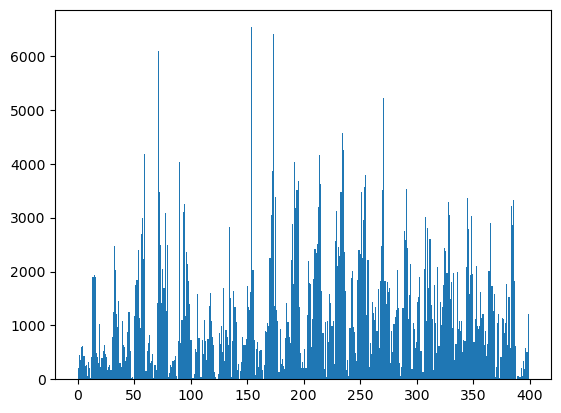

In [17]:
plt.hist(pred, bins=400);

In [21]:
n=20
weights = som_wide.weights
weights = weights.reshape((n, n, 4))

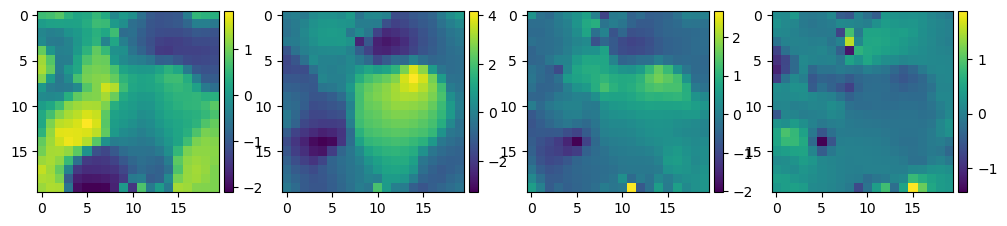

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i in range(4):
    im = axes[i].imshow(weights[:,:,i])
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

fig.subplots_adjust(wspace=0.25)
plt.show()

In [23]:
weights[:,:,0]

array([[ 5.89679267e-01,  6.59127106e-01,  7.97597398e-01,
         4.13785976e-01,  2.11232574e-01,  2.67604334e-01,
         5.12190132e-01,  2.85322265e-01, -2.74329933e-01,
         1.01064489e-02, -1.52141201e-01, -6.64044440e-01,
        -1.00246662e+00, -1.11283759e+00, -1.08313939e+00,
        -1.03479151e+00, -4.65142927e-01,  5.01886463e-01,
         4.23612468e-01,  3.53738091e-01],
       [ 7.14933691e-02,  1.35298137e-01,  1.60244770e-01,
         1.48586034e-01,  1.57097403e-01,  3.24661213e-01,
         5.85017528e-01,  5.54626268e-01,  1.87131105e-02,
        -1.73157883e-01, -6.72723016e-01, -7.87147074e-01,
        -1.06480408e+00, -1.11923700e+00, -1.08482757e+00,
        -1.01495832e+00, -7.99289189e-01, -4.16793848e-01,
        -4.14833893e-01, -5.36450519e-01],
       [-3.02604817e-01, -3.97711384e-01, -3.56669083e-01,
        -1.08666122e-01,  1.51258124e-02,  2.09690790e-01,
         3.83067424e-01,  2.42962963e-01,  6.04588764e-01,
        -7.01166287e-01, -6.5

In [24]:
data = raw_data[mag_mask]

In [25]:
data['cell_wide']=pred

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
square = data[['zspec', 'cell_wide']].groupby('cell_wide').agg(['mean', 'median', 'std'])

im = square[('zspec',   'mean')].values.reshape(20,20)

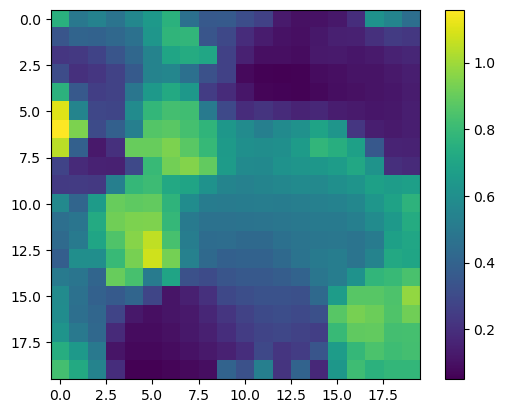

In [29]:
plt.imshow(im)
plt.colorbar()

### With DES Deep Fields

0 U
1 G


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


2 R
3 I
4 Z
5 J
6 H
7 KS


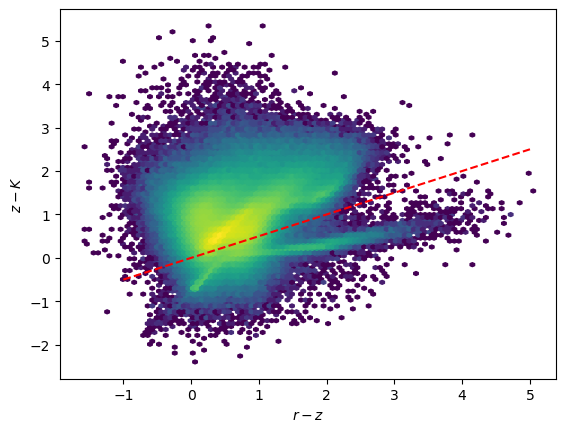

In [2]:
import pandas as pd
def flux2mag(flux):
    return -2.5 * np.log10(flux) + 30


df = pd.read_table('/project2/chihway/raulteixeira/data/deepfields.csv.gz', sep=',', header=0)


# Mask flagged regions
mask = df.MASK_FLAGS_NIR==0
mask &= df.MASK_FLAGS==0
mask &= df.FLAGS_NIR==0
mask &= df.FLAGS==0
mask &= df.FLAGSTR=="b'ok'"
mask &= df.FLAGSTR_NIR=="b'ok'"
df = df[mask]
df = df.drop(columns=[
    "MASK_FLAGS",
    "MASK_FLAGS_NIR",
    "FLAGS",
    "FLAGS_NIR",
    "FLAGSTR",
    "FLAGSTR_NIR",
])

deep_bands_ = ["U","G","R","I","Z","J","H","KS"]
# remove crazy colors, defined as two 
# consecutive colors (e.g u-g, g-r, r-i, etc) 
# that have a value smaler than -1
mags_d = np.zeros((len(df),len(deep_bands_)))
magerrs_d = np.zeros((len(df),len(deep_bands_)))

for i,band in enumerate(deep_bands_):
    print(i,band)
    mags_d[:,i] = flux2mag(df['BDF_FLUX_DERED_CALIB_%s'%band])

colors = np.zeros((len(df),len(deep_bands_)-1))
for i in range(len(deep_bands_)-1):
    colors[:,i] = mags_d[:,i] - mags_d[:,i+1]

normal_colors = np.mean(colors > -1, axis=1) == 1
normal_colors.sum()

df = df[normal_colors]

# mask faint objects, i < 25
df = df[flux2mag(df.BDF_FLUX_DERED_CALIB_I.values) < 25]

i = flux2mag(df.BDF_FLUX_DERED_CALIB_I.values)
r = flux2mag(df.BDF_FLUX_DERED_CALIB_R.values)
z = flux2mag(df.BDF_FLUX_DERED_CALIB_Z.values)
k = flux2mag(df.BDF_FLUX_DERED_CALIB_KS.values)


plt.hexbin((r-z), (z-k), gridsize=100, mincnt=1, bins='log')
_t = np.linspace(-1, 5, 100)
plt.plot(_t, 0.5*_t, color='r', ls='--')
plt.xlabel(r"$r-z$")
plt.ylabel(r"$z-K$")
plt.show()

# mask stars based on (z−K) > 0.5×(r −z) color cut

df = df[(z-k) > 0.5*(r-z)]

In [168]:
#df.to_csv('/project2/chihway/raulteixeira/data/deepfields_clean.csv.gz', header=True, index=False)

In [3]:
deep=df

In [4]:
deep_bands = ['I', 'G', 'R', 'Z', 'U', 'J', 'H', 'KS']
deep_fluxes = deep[(f'BDF_FLUX_DERED_CALIB_{band}' for band in deep_bands)].values
deep_vars = deep[(f'BDF_FLUX_ERR_DERED_CALIB_{band}' for band in deep_bands)].values

In [7]:
%%time
deep_lupts = np.array([luptize_deep(deep_flux, var=deep_var) for (deep_flux, deep_var) in zip(deep_fluxes, deep_vars)])
deep_luptitudes, deep_lupts_var = deep_lupts[:,0], deep_lupts[:,1]


CPU times: user 26.6 s, sys: 746 ms, total: 27.4 s
Wall time: 27.1 s


In [156]:
deep_luptitudes.T[3]

array([15.54613994, 15.07868907, 15.01012719, ..., 14.83991488,
       14.51163902, 16.66665365])

In [8]:
#deep_lupt_i, deep_lupt_g, deep_lupt_r, deep_lupt_z = deep_luptitudes.T
#deep_lupt_gi, deep_lupt_ri, deep_lupt_zi = deep_lupt_g-deep_lupt_i, deep_lupt_r-deep_lupt_i, deep_lupt_z-deep_lupt_i
#deep_input = np.array([deep_lupt_i, deep_lupt_gi, deep_lupt_ri, deep_lupt_zi]).T
deep_input = [0]*8
deep_lupt_i = deep_luptitudes.T[0]
deep_input[0] = deep_lupt_i
j=1
for k, deep_lupt in enumerate(deep_luptitudes.T[1:]):
    deep_input[j]=deep_lupt-deep_lupt_i
    print(f'{deep_bands[k+1]}-I')
    j+=1
    
deep_input = np.array(deep_input)

G-I
R-I
Z-I
U-I
J-I
H-I
KS-I


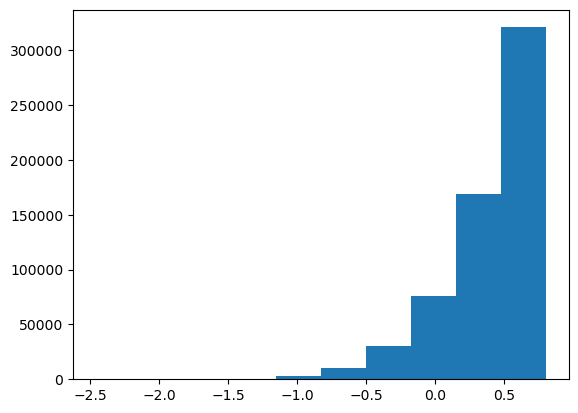

In [158]:
#normalizing i-band luptitude
deep_median_i = np.median(deep_lupt_i)
deep_std_i = np.std(deep_lupt_i)

deep_nlupt_i = (deep_lupt_i-deep_median_i)/deep_std_i
plt.hist(deep_nlupt_i*0.34+0.5)
plt.show()

In [159]:
deep_medians[0]

17.594663786698153

In [201]:
deep_medians = np.median(deep_input, axis=1)
deep_stds = np.std(deep_input, axis=1)
deep_n_input = (deep_input.T-deep_medians)/deep_stds
deep_n_input = (deep_n_input-deep_n_input.min())/(deep_n_input.max()-deep_n_input.min())

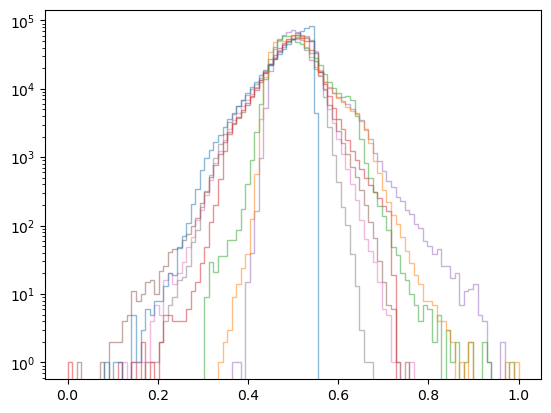

In [202]:
plt.hist(deep_n_input, alpha=.5, histtype='step', bins = np.linspace(0, 1, 100))
plt.yscale('log')
plt.show()

In [162]:
n = 48
som_deep = SOM(m=n, n=n, dim=8)

In [163]:
deep_n_input.shape

(610328, 8)

In [203]:
%%time
np.random.seed(42)
som_deep.fit(deep_n_input, epochs=1) #submit job

CPU times: user 19min 18s, sys: 24.8 s, total: 19min 43s
Wall time: 19min 45s


In [204]:
%%time
pred = som_deep.predict(deep_n_input)

CPU times: user 18min 50s, sys: 20.5 s, total: 19min 10s
Wall time: 19min 11s


In [205]:
deep_weights = som_deep.weights
deep_weights = deep_weights.reshape((n, n, 8))

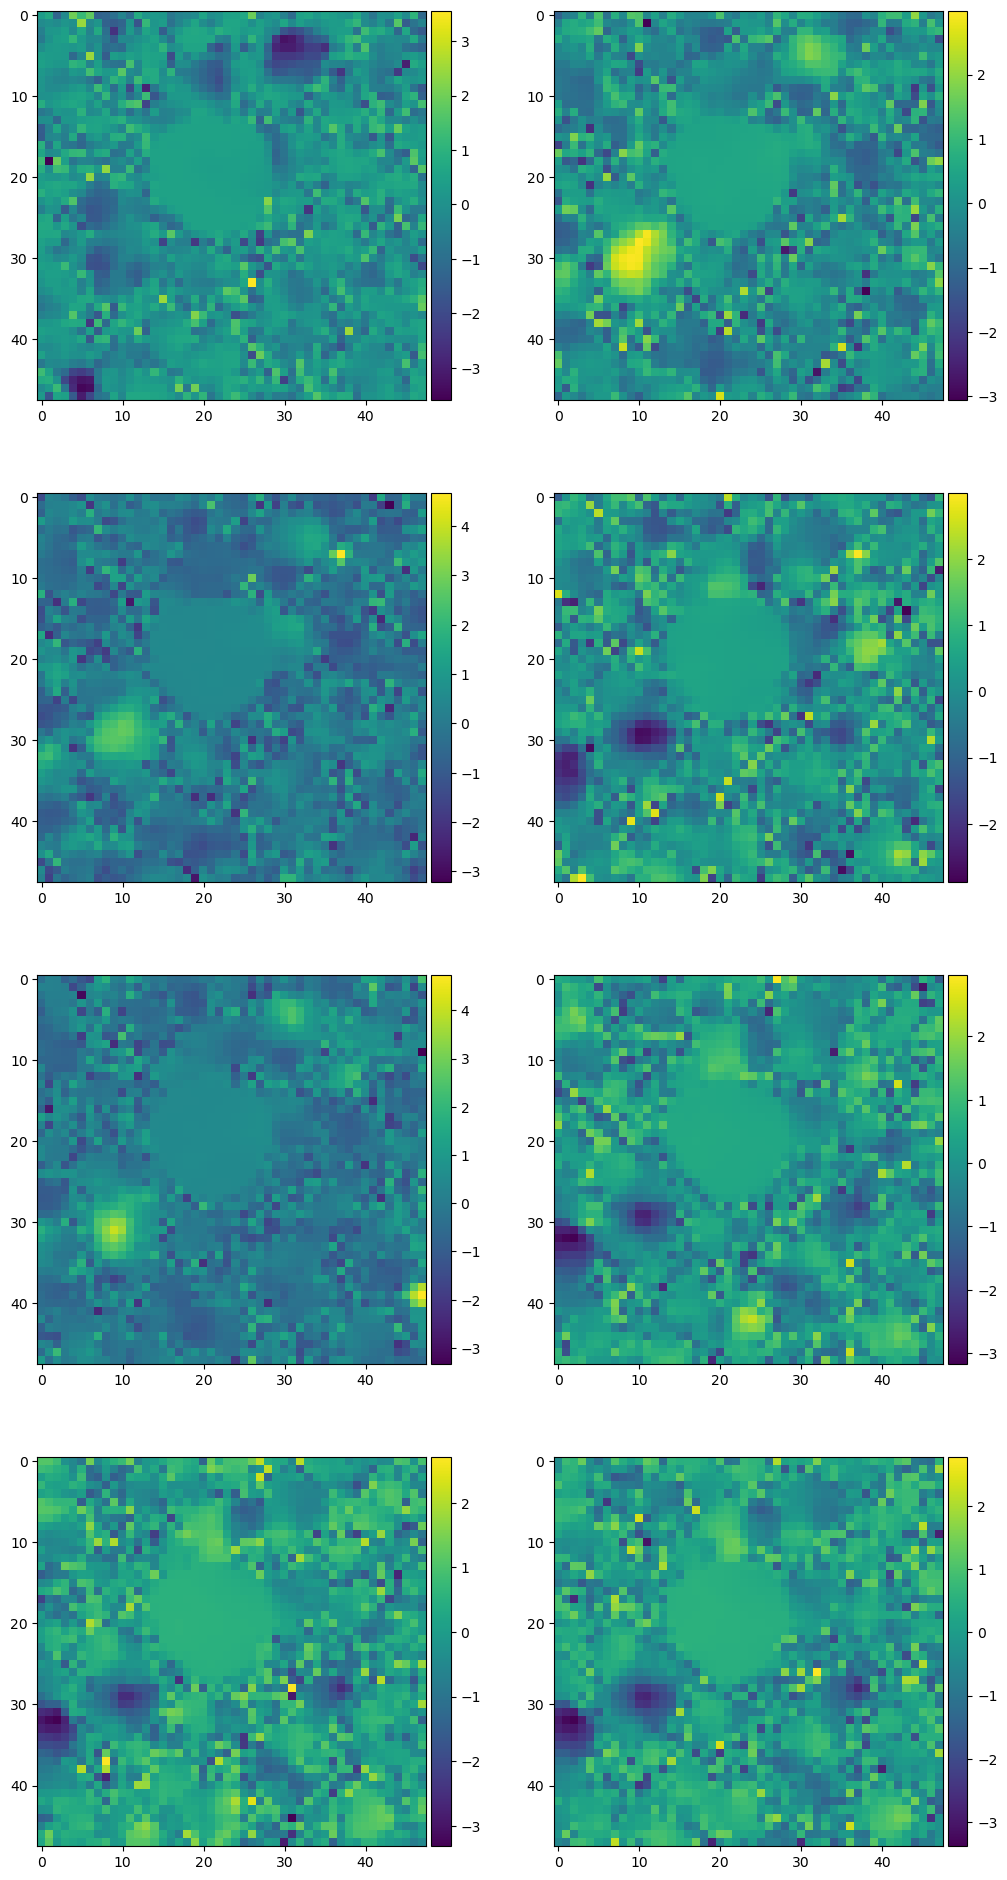

In [206]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(4, 2, figsize=(12, 24))

for i in range(4):
    for j in range(2):
        im = axes[i,j].imshow(deep_weights[:,:,2*i+j])
        divider = make_axes_locatable(axes[i,j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

fig.subplots_adjust(wspace=0.25)
plt.show()

In [169]:
specz = pd.read_csv('/project2/chihway/raulteixeira/data/deepfields_specz.csv.gz')

specz['cell_wide']=pred

square = specz[['zspec', 'cell_wide']].groupby('cell_wide').agg(['mean', 'median', 'std'])

im = np.zeros(n*n)+np.nan

indices = np.array(square.index)

im[indices]=square[('zspec', 'mean')].values

im=im.reshape(n,n);

plt.imshow(im)
plt.colorbar()

In [ ]:
#script



In [9]:
%%time
import sklearn as skl
import sklearn_som
from sklearn_som.som import SOM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

def flux2mag(flux):
    return -2.5 * np.log10(flux) + 30


df = pd.read_table('/project2/chihway/raulteixeira/data/deepfields.csv.gz', sep=',', header=0)


# Mask flagged regions
mask = df.MASK_FLAGS_NIR==0
mask &= df.MASK_FLAGS==0
mask &= df.FLAGS_NIR==0
mask &= df.FLAGS==0
mask &= df.FLAGSTR=="b'ok'"
mask &= df.FLAGSTR_NIR=="b'ok'"
df = df[mask]
df = df.drop(columns=[
    "MASK_FLAGS",
    "MASK_FLAGS_NIR",
    "FLAGS",
    "FLAGS_NIR",
    "FLAGSTR",
    "FLAGSTR_NIR",
])

deep_bands_ = ["U","G","R","I","Z","J","H","KS"]
# remove crazy colors, defined as two 
# consecutive colors (e.g u-g, g-r, r-i, etc) 
# that have a value smaler than -1
mags_d = np.zeros((len(df),len(deep_bands_)))
magerrs_d = np.zeros((len(df),len(deep_bands_)))

for i,band in enumerate(deep_bands_):
    print(i,band)
    mags_d[:,i] = flux2mag(df['BDF_FLUX_DERED_CALIB_%s'%band])

colors = np.zeros((len(df),len(deep_bands_)-1))
for i in range(len(deep_bands_)-1):
    colors[:,i] = mags_d[:,i] - mags_d[:,i+1]

normal_colors = np.mean(colors > -1, axis=1) == 1
normal_colors.sum()

df = df[normal_colors]

# mask faint objects, i < 25
df = df[flux2mag(df.BDF_FLUX_DERED_CALIB_I.values) < 25]

i = flux2mag(df.BDF_FLUX_DERED_CALIB_I.values)
r = flux2mag(df.BDF_FLUX_DERED_CALIB_R.values)
z = flux2mag(df.BDF_FLUX_DERED_CALIB_Z.values)
k = flux2mag(df.BDF_FLUX_DERED_CALIB_KS.values)

# mask stars based on (z−K) > 0.5×(r −z) color cut

df = df[(z-k) > 0.5*(r-z)]

deep=df

deep_bands = ['I', 'G', 'R', 'Z', 'U', 'J', 'H', 'KS']
deep_fluxes = deep[(f'BDF_FLUX_DERED_CALIB_{band}' for band in deep_bands)].values
deep_vars = deep[(f'BDF_FLUX_ERR_DERED_CALIB_{band}' for band in deep_bands)].values

deep_lupts = np.array([luptize_deep(deep_flux, var=deep_var) for (deep_flux, deep_var) in zip(deep_fluxes, deep_vars)])
deep_luptitudes, deep_lupts_var = deep_lupts[:,0], deep_lupts[:,1]

deep_input = [0]*8
deep_lupt_i = deep_luptitudes.T[0]
deep_input[0] = deep_lupt_i
j=1
for deep_lupt in deep_luptitudes.T[1:]:
    deep_input[j]=deep_lupt-deep_lupt_i
    j+=1
    
deep_input = np.array(deep_input)

#normalizing i-band luptitude
deep_median_i = np.median(deep_lupt_i)
deep_std_i = np.std(deep_lupt_i)

deep_nlupt_i = (deep_lupt_i-deep_median_i)/deep_std_i

deep_medians = np.median(deep_input, axis=1)
deep_stds = np.std(deep_input, axis=1)
deep_n_input = (deep_input.T-deep_medians)/deep_stds
#comment out line below to use unit variance
deep_n_input = (deep_n_input-deep_n_input.min())/(deep_n_input.max()-deep_n_input.min())

0 U
1 G
2 R
3 I
4 Z
5 J
6 H
7 KS
CPU times: user 41.4 s, sys: 2.6 s, total: 44 s
Wall time: 43.7 s


0 U
1 G
2 R
3 I
4 Z
5 J
6 H
7 KS


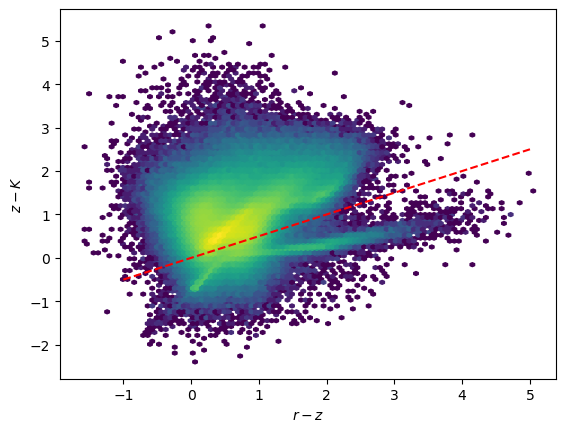

In [151]:
n = 48
som_deep = SOM(m=n, n=n, dim=8)

np.random.seed(42)
som_deep.fit(deep_n_input, epochs=10)
pred = som_deep.predict(deep_n_input)

deep_weights = som_deep.weights
deep_weights = deep_weights.reshape((n, n, 8))

specz = pd.read_csv('/project2/chihway/raulteixeira/data/deepfields_specz.csv.gz')

specz['cell_wide']=pred

#UV stands for unit variance
specz.to_csv('/project2/chihway/raulteixeira/data/deepfields_specz_SOMpred_10epochs_UV.csv.gz')